In [1]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import matplotlib.pyplot as plt
import tensorflow as tf
from cmapss.utils.utils import (clean_test_dataf, clean_train_dataf,
                                encode_rul, get_rejected_features,
                                lag_dataframe, scale_test_dataf,
                                scale_train_dataf)
from sklearn.model_selection import GroupShuffleSplit
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers

from datasets import load_dataset

/home/csng/Projects/datasets/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-21 15:57:13.086575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-21 15:57:13.430184: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
columns = ['machine_number', 'uptime', 'setting_1', 'setting_2', 'setting_3']
sensor_measurements = [f'sensor_{i:02d}' for i in range(1, 25)]
columns += sensor_measurements

dataset = load_dataset("csv",
                       data_files={"train": "./cmapss/data/train_FD001.txt",
                                   "test": "./cmapss/data/test_FD001.txt"},
                       sep=" ",
                       column_names=columns)

target_dataset = load_dataset("csv",
                              data_files={"target": "./cmapss/data/RUL_FD001.txt"},
                              column_names=["RUL"])

Using custom data configuration default-2bbdd18b42c15eb2
Found cached dataset csv (/home/csng/.cache/huggingface/datasets/csv/default-2bbdd18b42c15eb2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 2/2 [00:00<00:00, 196.84it/s]
Using custom data configuration default-a39fa80f1f115dcc
Found cached dataset csv (/home/csng/.cache/huggingface/datasets/csv/default-a39fa80f1f115dcc/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 1/1 [00:00<00:00, 616.99it/s]


In [3]:
rejected_features = get_rejected_features(filename="./cmapss/rejected_features.txt")

# Drop rejected features from both train and test set
dataset = dataset.remove_columns(rejected_features + ['sensor_22', 'sensor_23', 'sensor_24'])

In [4]:
# For now, we convert the dataset to a `pandas` structure. In the future,
# the plan is to utilise the `datasets` functionality more in order to
# standardise the processing method.
df_train = dataset["train"].to_pandas()
df_test = dataset["test"].to_pandas()

# Load the y_test and join to df_test. This is the target RUL.
y_test = target_dataset["target"].to_pandas()
y_test["machine_number"] = y_test.index + 1
df_test = df_test.join(y_test.set_index('machine_number'), on='machine_number')

# Pre-process data

In [5]:
def preprocess_data(df_train, df_test):
    num_lags = 30

    # Run pre-processing on train set with encoded RUL
    clean_df_train = (df_train
                      .pipe(clean_train_dataf, rejected_features=None)
                      .pipe(encode_rul)
                      .drop(columns=['uptime'])
                      )
    # Split this pipe step to store scaler for later reuse
    clean_df_train, scaler = clean_df_train.pipe(scale_train_dataf)
    clean_df_train = clean_df_train.pipe(lag_dataframe, num_lags=num_lags)

    # Run pre-processing on test set with encoded RUL
    clean_df_test = (df_test
                     .pipe(clean_test_dataf, rejected_features=None)
                     .pipe(encode_rul)
                     .drop(columns=['uptime'])
                    )
    clean_df_test = clean_df_test.pipe(scale_test_dataf, scaler=scaler)
    clean_df_test = clean_df_test.pipe(lag_dataframe, num_lags=num_lags)

    return clean_df_train, clean_df_test

In [6]:
clean_df_train, clean_df_test = preprocess_data(df_train, df_test)

In [7]:
x_train = clean_df_train.copy()
y_train = x_train.pop('RUL').astype(float)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)

x_test = clean_df_test.copy()
y_test = x_test.pop('RUL').astype(float)

# Drop 'machine_number' from the train/test
machine_number = x_train.pop('machine_number')
_ = x_test.pop('machine_number')

# x_train, x_val, y_train, y_val = train_test_split(
#     x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [8]:
def scheduler(epoch, lr):
    # Define a custom scheduler to vary learning rate based on epoch
    # Based on: https://doi.org/10.1016/j.ress.2017.11.021, page 5
    if epoch < 100:
      return lr
    else:
      lr = 1e-4
      return lr

# Create callback for scheduling learning rate
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [9]:
# Create the model using the functional API approach
num_features = x_train.shape[1]
inputs = keras.Input(shape=(num_features,))
x = layers.Dense(800, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(700, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="classification_model")

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics='accuracy'
)

2022-11-21 15:57:19.657644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in gss.split(x_train, y_train, groups=machine_number):
    x_val = x_train.iloc[val_idx]
    y_val = y_train[val_idx]
    x_train = x_train.iloc[train_idx]
    y_train = y_train[train_idx]

    history = model.fit(x=x_train,
                        y=y_train,
                        epochs=5,
                        # Suppress logging.
                        # verbose=0,
                        validation_data=(x_val, y_val),
                        callbacks=[callback],)

Epoch 1/5
443/443 [==============================] - 6s 11ms/step - loss: 0.4212 - accuracy: 0.8176 - val_loss: 0.3054 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 2/5
443/443 [==============================] - 5s 11ms/step - loss: 0.3376 - accuracy: 0.8540 - val_loss: 0.3075 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 3/5
443/443 [==============================] - 5s 11ms/step - loss: 0.3247 - accuracy: 0.8625 - val_loss: 0.2822 - val_accuracy: 0.8772 - lr: 0.0010
Epoch 4/5
443/443 [==============================] - 5s 12ms/step - loss: 0.3068 - accuracy: 0.8696 - val_loss: 0.2914 - val_accuracy: 0.8599 - lr: 0.0010
Epoch 5/5
443/443 [==============================] - 5s 11ms/step - loss: 0.3025 - accuracy: 0.8723 - val_loss: 0.2838 - val_accuracy: 0.8764 - lr: 0.0010


In [11]:
def plot_loss(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(history.history['loss'], label='train_loss')
    axs[0].plot(history.history['val_loss'], label='val_loss')
    axs[1].plot(history.history['accuracy'], label='train_acc')
    axs[1].plot(history.history['val_accuracy'], label='val_acc')
    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()
        ax.grid(True)
    axs[0].set_ylabel('RUL')
    axs[1].set_ylabel('Acc RUL')

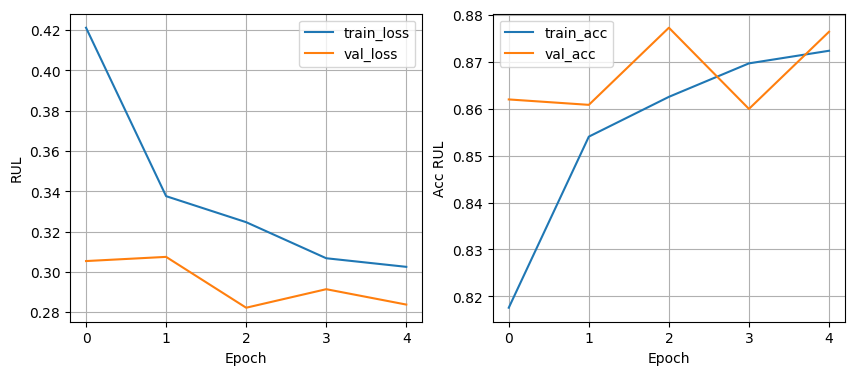

In [12]:
plot_loss(history)
plt.show()

In [13]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
y_test_ = tf.keras.utils.to_categorical(y_test, num_classes=3)
results = model.evaluate(x_test, y_test_)
print("test loss, test accuracy:", results)
# print(f"test rmse {np.sqrt(results[1]):.4f}")

Evaluate on test data
316/316 [==============================] - 1s 3ms/step - loss: 0.2415 - accuracy: 0.9117
test loss, test accuracy: [0.2414880096912384, 0.9117472171783447]
